# Moments (invariant)

Moments can be used to describe, characterize, and quantify the shape of an object in an image, such as  hu moments.

Hu moments are normally extracted from the outline of an object in an image. By describing the outline (silhouette ) of an object, we are able to extract a shape feature vector (i.e. a set of numerical values) to represent the shape of the object.

TO compare or match two objects, we may calculate a similarity metric of their corresponding vectors 



Here we will prove that using HUmomonets with the right similarity metric can help detect the same object in diffrent images under many variation(rotation, translation.....

In [7]:
import cv2
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from nltk import flatten
import math as m


# 1/Create the dataset:
we chose the image "pegasus-unicorn.jpg" and the object will be a unicorn

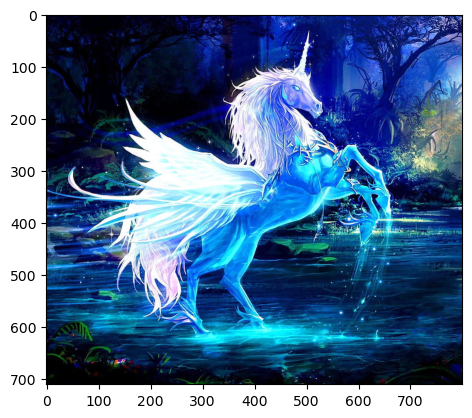

In [2]:
image = cv2.imread("pegasus-unicorn.jpg",cv2.IMREAD_UNCHANGED)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

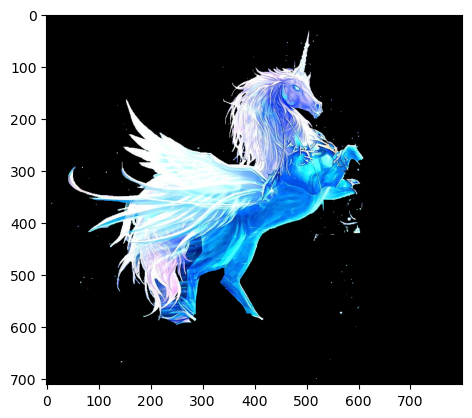

In [3]:
#Foreground Extraction (since we only care about the unicorn) using GrabCut Algorithm
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (10,10,600,700)
mask = np.zeros(image.shape[:2],np.uint8)
new_mask, fg, bg=cv2.grabCut(image,mask,rect,bgdModel,fgdModel,2,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((new_mask==2)|(new_mask==0),0,1).astype('uint8') 

pegasus=image*mask2[:,:,np.newaxis] 
plt.imshow(pegasus)

In [4]:
# creat pegasus data: [originaL,rotated,translated, mirrord,mirrord_translated]
M = np.float32([[1,0,150],[0,1,100]])
w,h,_=pegasus.shape
pegasus_images=['originaL','rotated','translated', 'mirrord','mirrord_translated']
pegasus_data=[pegasus, cv2.rotate(pegasus, cv2.ROTATE_90_CLOCKWISE),cv2.warpAffine(pegasus,M,(w,h)),cv2.flip(pegasus, 1),cv2.warpAffine(cv2.flip(pegasus, 0),M,(w,h))]

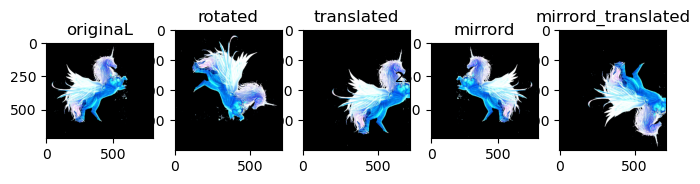

In [5]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = pegasus_data[i-1]
    fig.add_subplot(rows, columns, i).set_title(pegasus_images[i-1])
    plt.imshow(img)
plt.show()

# Compute the Hu moments of each image

So this is our images and we will calculate the Hu moments for each on of them, we follow these steps:

__1.__Convert each image to grayscale: Hu moments are calculated from the grayscale values of an image, so you need to convert your color images to grayscale first.

__2.__Threshold the image: To extract the object from the background, you may need to apply a threshold to the image. This will convert the grayscale values to binary values (0 or 1) based on a threshold value you choose.

__3.__Calculate the moments: Use an image processing library or software to calculate the image moments for each image. The moments are calculated from the pixel values of the binary image using mathematical formulas.

__4.__Normalize the moments: Normalize the moments to make them scale-invariant and rotation-invariant. Hu moments are a set of seven normalized moments, so you need to use the formulas to calculate these normalized moments.

__5.__Calculate the Hu moments: Use the normalized moments to calculate the Hu moments. The Hu moments are a set of seven values that describe the shape of the object in the image.

In [8]:

# Calculate Moments
pegasus_images=['originaL','rotated','translated', 'mirrord','mirrord_translated']
columns = ["H0", "H1", "H2", "H3", "H4", "H5", "H6","image"]
d=[]
data = pd.DataFrame(columns=columns)
for i in range(5):
    moments = cv2.moments(cv2.cvtColor(pegasus_data[i], cv2.COLOR_RGB2GRAY))  
    huMoments = flatten(cv2.HuMoments(moments).tolist())
    for j in range(7):
        huMoments[j] = -1* m.copysign(1.0, huMoments[i]) * m.log10(abs(huMoments[i]))#log transform to bring huMoments in the same range¶
    d.append(huMoments)
    d[i].append(pegasus_images[i])
df = pd.DataFrame(d,columns = columns)


In [10]:
df

,H0,H1,H2,H3,H4,H5,H6,image
0,2.924103,-0.465993,-0.465993,-0.465993,-0.465993,-0.465993,-0.465993,originaL
1,6.501955,6.501955,-0.813044,-0.813044,-0.813044,-0.813044,-0.813044,rotated
2,10.205904,10.205904,10.205904,-1.008851,-1.008851,-1.008851,-1.008851,translated
3,10.780649,10.780649,10.780649,10.780649,-1.032645,-1.032645,-1.032645,mirrord
4,21.351107,21.351107,21.351107,21.351107,21.351107,-1.329420,-1.329420,mirrord_translated


# Use similarity metrics to comare all the images with the original one.


## Euclidean distance

In [11]:
from scipy.spatial.distance import euclidean
original=df[(df['image']=='originaL')].iloc[:,:-1].values.flatten().tolist()

for i in range(4):
    transformed=df[(df['image']==pegasus_images[i+1])].iloc[:,:-1].values.flatten().tolist()
    
    distance = euclidean(original, transformed)
    print(f"The Euclidean distance between the originaL image and the {pegasus_images[i+1]} image is:", distance)

The Euclidean distance between the originaL image and the rotated image is: 7.871184208691396
The Euclidean distance between the originaL image and the translated image is: 16.79232469175642
The Euclidean distance between the originaL image and the mirrord image is: 21.02735021357577
The Euclidean distance between the originaL image and the mirrord_translated image is: 47.38131343463981


In [12]:
from scipy.spatial.distance import cosine
original=df[(df['image']=='originaL')].iloc[:,:-1].values.flatten().tolist()

for i in range(4):
    transformed=df[(df['image']==pegasus_images[i+1])].iloc[:,:-1].values.flatten().tolist()
    
    distance = 1 - cosine(original, transformed)
    print(f"The cosine similarity between the originaL image and the {pegasus_images[i+1]} image is:", distance)


The cosine similarity between the originaL image and the rotated image is: 0.6075972198948901
The cosine similarity between the originaL image and the translated image is: 0.3977142823053217
The cosine similarity between the originaL image and the mirrord image is: 0.26351619077492505
The cosine similarity between the originaL image and the mirrord_translated image is: 0.15918165853278854


## Dynamic time warping combined with ecludean distance: 
the similarity in this case will be DTW aligment cost which is the last value in the cost matrix returned by the DWT algorithm that uses ecludean distance as at ditance matrix

The four values returned by the dtw function are:

1/The DTW distance between the two input sequences.

2/The accumulated cost matrix used to compute the DTW distance.

3/The optimal path between the two input sequences, which is a list of tuples representing the indices of the aligned elements in each sequence.

4/The accumulated cost matrix normalized by the length of the path, which is the same as the DTW distance if the path is constrained to be monotonically increasing.


In [13]:
import numpy as np
from dtw import dtw

original=df[(df['image']=='originaL')].iloc[:,:-1].values.flatten().tolist()

for i in range(4):
    transformed=df[(df['image']==pegasus_images[i+1])].iloc[:,:-1].values.flatten().tolist()
    x = original
    y = transformed
    dist, cost, acc_cost, path = dtw(x, y, dist=lambda x, y: abs(x - y))
    print(f"the similarity(aligment cost) between the otiginal image and the {pegasus_images[i+1]} image is :", cost[-1,-1])
    
    #print("DTW distance between x and y:", dist)
    #print("DTW accumulated aligment cost matrix:", acc_cost[-1,-1])
    #print("DTW optimal path:", path)

the similarity(aligment cost) between the otiginal image and the rotated image is : 0.34705131301324743
the similarity(aligment cost) between the otiginal image and the translated image is : 0.5428588424456614
the similarity(aligment cost) between the otiginal image and the mirrord image is : 0.5666522738159577
the similarity(aligment cost) between the otiginal image and the mirrord_translated image is : 0.863427761258304


# Explaining the choice of matrices
Euclidean distance: Euclidean distance is a commonly used distance metric in many applications, It is simple to compute and can handle datasets with a large number of features. Euclidean distance is appropriate when the magnitude and direction of the features are both important for the similarity calculation, and when the dataset is not too noisy.

Cosine similarity: Cosine similarity is a distance metric that measures the similarity between two vectors in terms of the angle between them. It is often used in text analysis and natural language processing, where the magnitude of the features is less important than the direction. Cosine similarity is appropriate when the dataset contains high-dimensional sparse vectors and when the magnitude of the features is not important.

Dynamic time warping (DTW): DTW is a distance metric that is often used to compare time series data. It takes into account the temporal structure of the data and can handle datasets with temporal variations, such as shifts or time warping. DTW is appropriate when the data is noisy or when there are temporal variations that need to be taken into account for the similarity calculation.

# intrepretation
as we can see Hu moments are indeed invariant to translation, scaling, and rotation if we compare by the power of magnitude. However, in case of complex shapes like ours due to numerical approximations and discretization of the moments, their invariance may be affected by noise, occlusions, and other factors that can change the shape of the object in the image.

but when we compare DWT with the ecludian distance we managed to get very close results __which indicates that we are dealing with the same object in all the pictures.__

with the help of __Log transform__ which is a common pre-processing step done by taking the natural logarithm of each element in the Hu moment vector will help to enhance the discriminative power of the features.
the fact that DTW provided better similarity scores than Euclidean distance suggests that there may have been some small variations in the feature vectors that affected the Euclidean distance and thats normal since the object was extracted using Grap cut algorithm.